In [1]:
pwd

'/home/abuzarmahmood/Downloads/pytau/pytau/how_to/notebooks'

# Imports

In [2]:
import pylab as plt
from scipy import stats
import tables
import os
from glob import glob
import numpy as np
import sys
pytau_base_dir = '/media/bigdata/projects/pytau'
sys.path.append(pytau_base_dir)
from pytau.utils import plotting
from pytau.changepoint_model import single_taste_poisson, advi_fit
from pytau.changepoint_preprocess import preprocess_single_taste

Using directory: /media/bigdata/projects/pytau/pytau/how_to/examples/saved_models


# Deal with paths

In [3]:
# Write to MODEL_SAVE_DIR.params
pytau_base_dir = '/home/abuzarmahmood/Downloads/pytau/'
param_file_path = f'{pytau_base_dir}/pytau/config/MODEL_SAVE_DIR.params'
save_model_path = f'{pytau_base_dir}/pytau/how_to/examples/saved_models'
with open(param_file_path, 'w') as f:
    f.write(save_model_path)

In [4]:
# Find hf5 file
h5_path_list = glob(os.path.join(pytau_base_dir, '**', 'AM*.h5'), recursive=True)

# Find or Download data

In [5]:
download_script_path = os.path.join(pytau_base_dir, 'pytau/how_to/scripts/download_test_data.sh')
if not len(h5_path_list):
    os.system(f'bash {download_script_path}')
    h5_path = glob(os.path.join(pytau_base_dir, '**', 'AM*.h5'), recursive=True)[0]
else:
    h5_path = h5_path_list[0]

In [6]:
h5_path

'/home/abuzarmahmood/Downloads/pytau/pytau/how_to/test_data/AM11_4Tastes_191030_114043_spike_trains_only/AM11_4Tastes_191030_114043_minimal.h5'

# Load Spike Train

In [23]:
wanted_dig_in_ind = 0
with tables.open_file(h5_path,'r') as hf5:
    dig_in_list = hf5.list_nodes('/spike_trains')
    wanted_dig_in = dig_in_list[wanted_dig_in_ind]
    spike_train = wanted_dig_in.spike_array[:]

In [24]:
spike_train.shape

(30, 35, 7000)

In [25]:
# Bin Spike Train

In [26]:
time_lims = [2000, 4000]
bin_width = 50
binned_spike_array = preprocess_single_taste(
    spike_array=spike_train,
    time_lims=time_lims,
    bin_width=bin_width,
    data_transform=None)

In [27]:
binned_spike_array.shape

(30, 35, 40)

# Infer Changepoints

In [28]:
# Create and fit model
n_fit = 40000
n_samples = 20000
n_states = 4
model = single_taste_poisson(binned_spike_array, n_states)
model, approx, lambda_stack, tau_samples, fit_data = \
        advi_fit(model = model, fit = n_fit, samples = n_samples)

Finished [100%]: Average Loss = 22,165


In [33]:
# Extract changepoint values
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = np.squeeze(stats.mode(int_tau, axis=0)[0])
scaled_mode_tau = (mode_tau*bin_width)+time_lims[0]

In [31]:
mode_tau

array([[12, 33, 34],
       [16, 16, 17],
       [ 8, 26, 27],
       [20, 21, 21],
       [21, 23, 38],
       [ 2, 14, 15],
       [10, 21, 23],
       [ 9, 18, 20],
       [ 7, 22, 24],
       [11, 29, 32],
       [ 5, 20, 22],
       [ 4, 19, 20],
       [ 8, 10, 13],
       [ 1, 30, 38],
       [ 9, 18, 38],
       [ 9, 21, 38],
       [ 4,  6, 27],
       [10, 12, 38],
       [ 8, 15, 30],
       [ 6,  9, 38],
       [ 2, 12, 34],
       [ 7, 18, 38],
       [ 1, 13, 22],
       [ 1, 26, 29],
       [18, 20, 34],
       [ 8, 18, 19],
       [ 2, 22, 24],
       [ 1, 30, 36],
       [ 1, 21, 38],
       [ 1, 36, 38]])

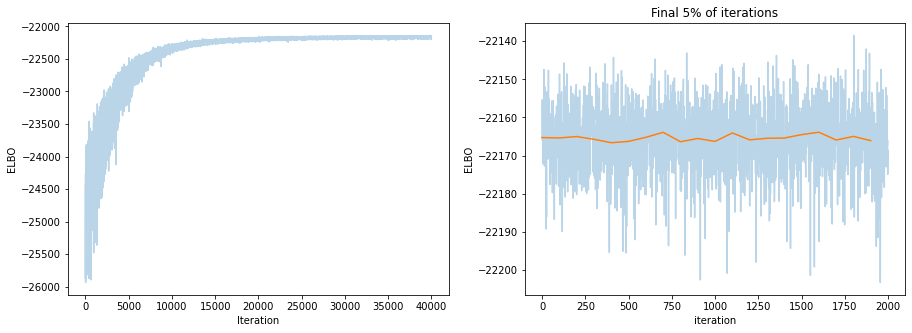

In [30]:
# Plot ELBO over iterations, should be flat by the end
fig, ax = plotting.plot_elbo_history(approx)
plt.show()

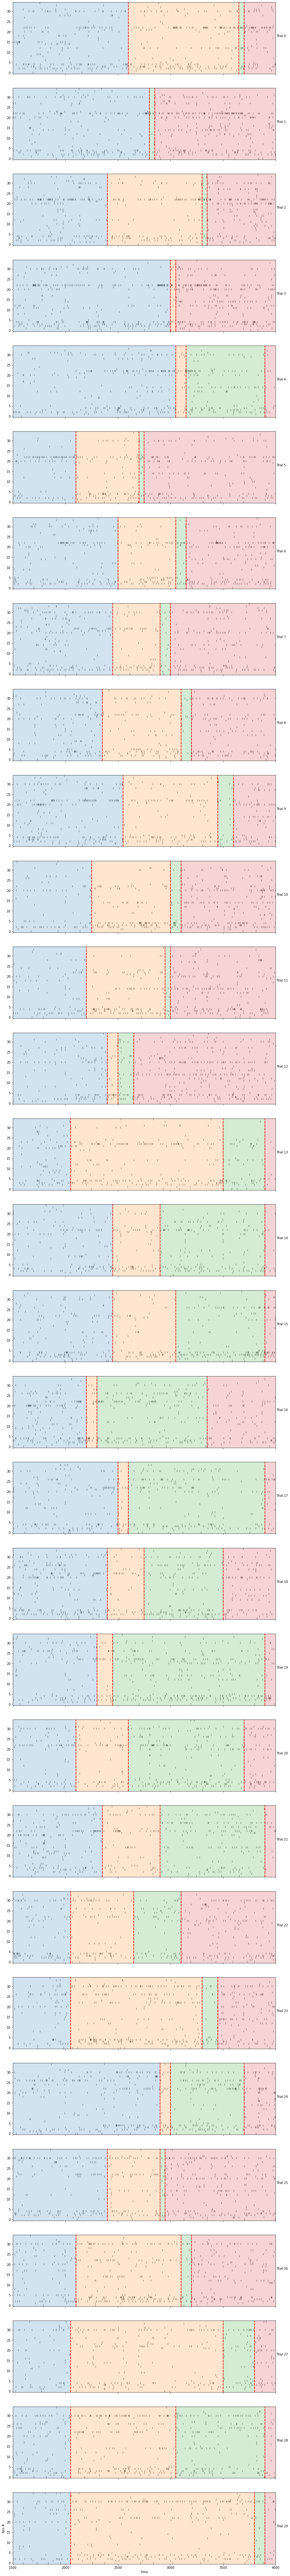

In [34]:
# Overlay raster plot with states
fig, ax = plotting.plot_changepoint_raster(
    spike_train, scaled_mode_tau, [1500, 4000])
plt.show()

/media/bigdata/projects/pytau/pytau/utils/plotting.py:119: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(np.arange(plot_lims[1]), np.arange(n_trials), state_durations)


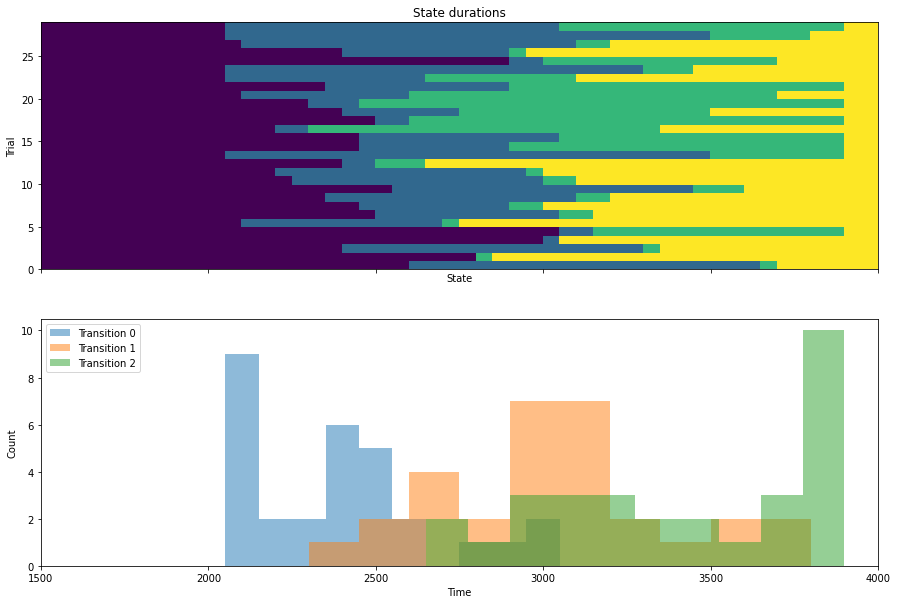

In [35]:
# Overview of changepoint positions
fig, ax = plotting.plot_changepoint_overview(scaled_mode_tau, [1500, 4000])
plt.show()

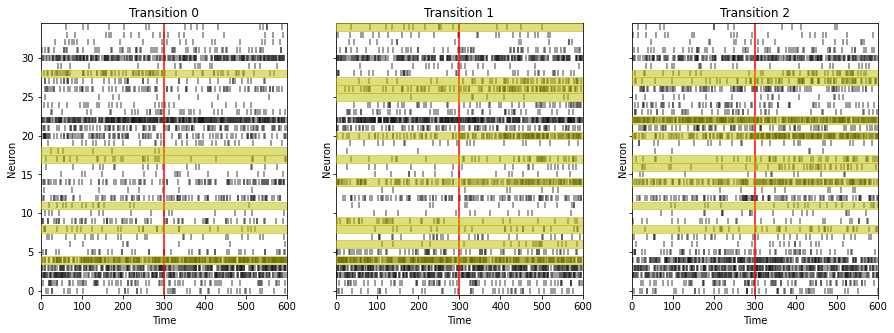

In [36]:
# Aligned spiking
fig, ax = plotting.plot_aligned_state_firing(spike_train, scaled_mode_tau, 300)
plt.show()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


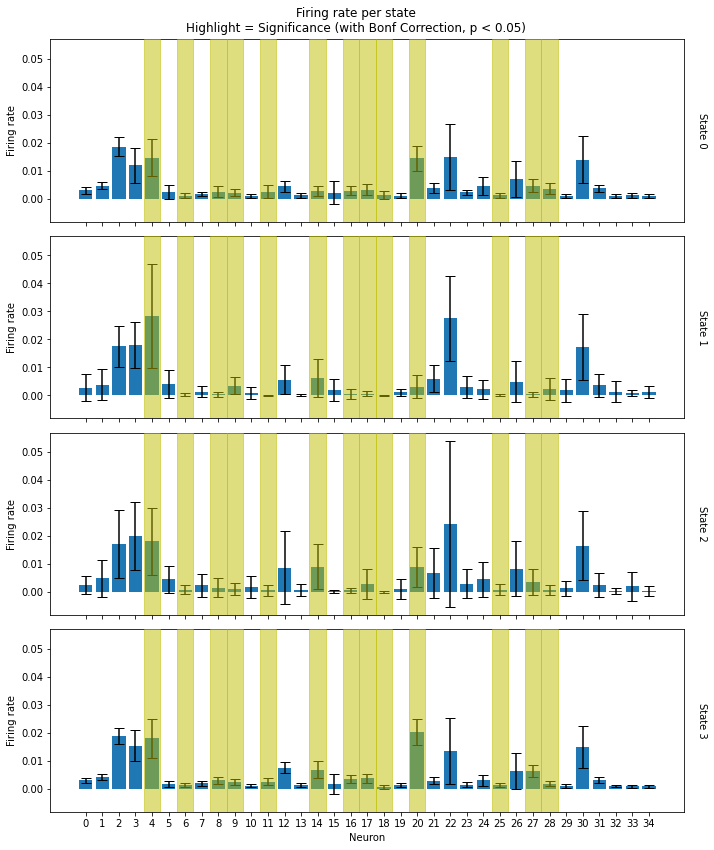

In [37]:
# Plot mean firing rates per state
fig, ax = plotting.plot_state_firing_rates(spike_train, scaled_mode_tau)
plt.show()